# DESI PV Y3 TFR Calibration - Tempel Merging Groups and Clusters Catalog

Using the list of merging galaxy groups and clusters defined by Tempel et. al in [Merging groups and clusters of galaxies from the SDSS data](https://doi.org/10.1051/0004-6361/201730499), identify observations with measurements suitable for calibrating the Tully-Fisher relation. 

Export the SGA IDs of the TFR galaxies in order to later apply a multi-group joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **11 April 2025** 

**Note:** This requires using a subclassed version of `hyperfit`. 

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse

c1 = plt.get_cmap('Dark2') 
c2 = plt.get_cmap('Set2')
c3 = plt.get_cmap('tab10')

# We have more than 10 clusters, so we need to change from the default color map so that they are all plotted with different colors
from cycler import cycler
tfcolor = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
(0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
(0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
(0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
(0.4, 0.6509803921568628, 0.11764705882352941),
(0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
(0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
(0.4, 0.7607843137254902, 0.6470588235294118),
(0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
(1.0, 0.4980392156862745, 0.054901960784313725),
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
(1.0, 0.8509803921568627, 0.1843137254901961),
(0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
(0.5529411764705883, 0.6274509803921569, 0.796078431372549),
(0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
(0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
(0.5803921568627451, 0.403921568627451, 0.7411764705882353),
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
(0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]
plt.rcParams['axes.prop_cycle'] = cycler('color', tfcolor)

import ligo.skymap.plot

from astropy.table import Table, QTable, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Jura Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')

sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI.fits')
sgatab = Table.read(sgafits)
print(len(sgatab), 'total SGA galaxies')
sgatab[:5]

35682 total SGA galaxies


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64
20,SGA-2020 20,SDSSJ173412.71+572041.6,3331584,263.5529355,57.34490699999999,S?,152.58,0.4487454,0.5333349,0.08364453,24.92448,18.036,False,LEDA-20181114,5,SDSSJ173412.71+572041.6,1,True,263.5529355,57.34490699999999,0.4487454,2635p572,263.55294849855886,57.344862145664294,0.4460123,SB26,152.3756,0.5778338,263.5528114673963,57.34481025685253,10.459747,5.9780583,5.751067,4.821581,1.4858595,3.4448266,5.1149526,6.748707,8.426254,9.720271,11.022999,12.0887985,13.380368,20.656942,20.044735,19.40886,19.194794,18.66572,18.231262,18.599888,18.123905,17.745926,18.256256,17.807074,17.476473,18.040592,17.60353,17.319197,17.926336,17.500519,17.228865,17.85259,17.42695,17.180876,17.811844,17.39206,17.151228,17.783718,17.36542,17.143204,0.02069058,0.026094317,0.03480586,0.05076174,0.08751116,0.10309491,0.08337893,0.10982923,0.13734566,0.031223593,0.046367057,0.0777883,0.015935475,0.020728666,0.032657374,0.012760426,0.014699919,0.022893604,0.010505663,0.011998588,0.018923525,0.010358521,0.011374098,0.017719442,0.010557283,0.0112259,0.017149422,0.010553381,0.011049819,0.0

# Load Morphological Classification using the SSL (Y1—do not use for Y3)

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [4]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
# ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphcsv = '/global/homes/m/mjkeller/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv'

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

SGA_ID,Predicted_Type_spiral,Predicted_Type_elliptical,Predicted_Type_irregular,Predicted_Type_lenticular,Predicted_Type
float64,str6,str10,str9,str10,str10
218203.0,Other,Other,Irregular,Other,Irregular
218205.0,Other,Other,Irregular,Other,Irregular
218239.0,Other,Other,Irregular,Other,Irregular
218275.0,Other,Other,Irregular,Other,Irregular
218304.0,Spiral,Other,Other,Other,Spiral


In [5]:
sum(ai_morphtab['Predicted_Type_spiral'] == 'Spiral') + sum(ai_morphtab['Predicted_Type_elliptical'] == 'Elliptical') + sum(ai_morphtab['Predicted_Type_lenticular'] == 'Lenticular') + sum(ai_morphtab['Predicted_Type_irregular'] == 'Irregular')

33995

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [6]:
'''# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in tqdm(range(len(ai_morphtab))):
    
    classes = ai_morphtab['Predicted_Type_spiral', 'Predicted_Type_elliptical', 'Predicted_Type_lenticular', 'Predicted_Type_irregular'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')''';

# Combine ML morphtypes with SGA catalog

In [7]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [8]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
        
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

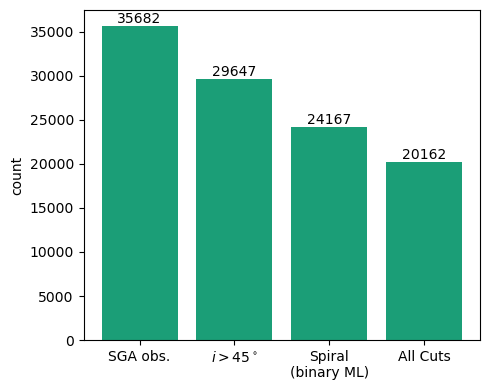

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [10]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [11]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [12]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [13]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [14]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [15]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [16]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$. Note that this still uses the Y1 dust correction!

In [17]:
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [18]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [19]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [20]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [21]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [22]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptab = Table.read('/global/homes/m/mjkeller/DESI_SGA/TF/SGA-2020_jura_Vrot_0pt_calib.fits')

In [23]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_jura_z0p1.fits', overwrite=True)
zeroptab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,MORPHTYPE_AI,MU_PRIMARY,MU_SECONDARY,MU_ERR,MU_SOURCE
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,bytes22
103123.0,SGA-2020 103123,SDSSJ074708.56+275429.4,4145061,116.785734,27.9081857,Sm,104.01,0.38282475,0.46344694,0.027839927,24.05848,17.515,False,LEDA-20181114,36629,SDSSJ074708.56+275429.4,1,True,116.785734,27.9081857,0.38282475,1168p280,116.78564045230306,27.908157346916912,0.5242874,SB26,105.55979,0.42825085,116.78555987055356,27.908243085963594,10.796608,5.006394,4.9300413,5.0233784,5.3875837,6.9426413,8.216747,9.404112,10.399142,11.295491,12.742218,14.235971,15.7286215,17.604733,17.260372,17.05073,17.319956,16.985378,16.785225,17.163937,16.835436,16.642214,17.066725,16.745531,16.559727,17.013998,16.69732,16.512413,16.98692,16.672842,16.485397,16.96346,16.646526,16.452162,16.950823,16.63161,16.42804,16.94372,16.621382,16.413736,0.119631045,0.13098262,0.124674216,0.08537393,0.14872828,0.10716611,0.19776088,0.30018482,0.19377819,0.051805183,0.0524946,0.052369807,0.047844343,0.048005756,0.048017472,0.04475182,0.044847436,0.04496339,0.04237442,0.042545233,0.04

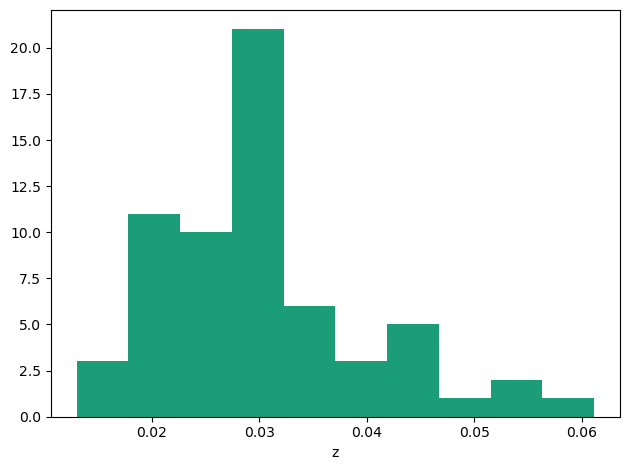

In [24]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [25]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [26]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=32>
        1999cc
        2000dg
        2001cj
        2001da
        2001ep
        2004bk
        2005hc
        2006az
        2006bt
        2006bw
        2006cq
        2007ba
           ...
 2013gy+2009kk
        2014ai
   ASASSN-15nr
   ASASSN-16ct
     AT2016bln
     AT2017cfc
       PS15aii
       PS16axi
       PS16ayd
       PS16bnz
        PS16fa
     SN2017ckx,
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  3,  3,  1,  1, 19,  1,
         4,  3,  1,  1,  1,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

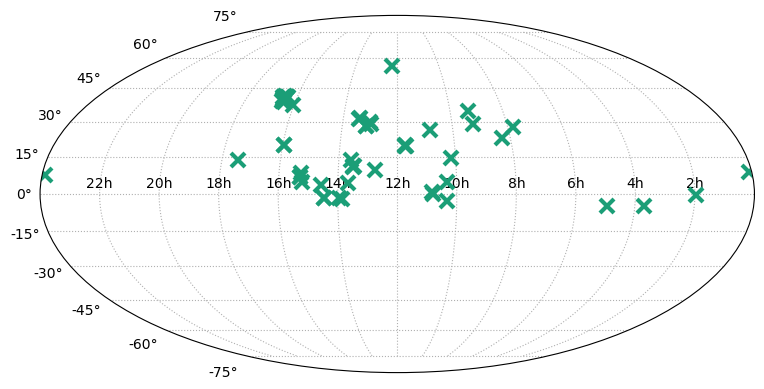

In [27]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

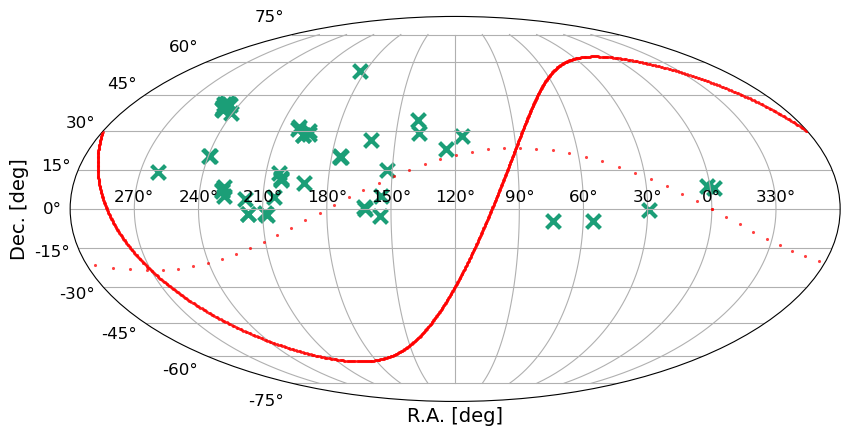

In [28]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3)

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [29]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [30]:
# Save this table
zeroptab.write('SGA-2020_jura_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These clusters come from the group catalog used by Tempel et al. in [*Merging groups and clusters of galaxies from the SDSS data: 
the catalogue of groups and potentially merging systems*](https://www.aanda.org/articles/aa/pdf/2017/06/aa30499-17.pdf), ApJ 896:3, 2020.

Cluster membership is defined using a modified friends-of-friends 

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [31]:
groups = Table.read('/global/homes/m/mjkeller/table1.dat', format = "ascii.no_header", names = ("GalID", "specID", "objID", "GroupID", "Ngal", "Rank", "Dist.g", "zob", "zcmb", "e_zobs", "Dist", "Distcor", "RAdeg", "DEdeg", "GLON", "GLAT", "SGLON", "SGLAT", "lambda", "eta", "Xpos", "Ypos", "Zpos", "umag", "gmag", "rmag", "imag", "zmag", "uMAG", "gMAG", "rMAG", "iMAG", "zMAG", "k+e.u", "k+e.g", "k+e.r", "k+e.i", "k+e.z", "ext.u", "ext.g", "ext.r", "ext.i", "ext.z", "Lr", "w", "pE", "pS0", "pSa", "pSc", "Dist.e", "Den1", "Den2", "Den4", "Den8"))
print(len(groups), 'galaxies')
groups[:10]

584449 galaxies


GalID,specID,objID,GroupID,Ngal,Rank,Dist.g,zob,zcmb,e_zobs,Dist,Distcor,RAdeg,DEdeg,GLON,GLAT,SGLON,SGLAT,lambda,eta,Xpos,Ypos,Zpos,umag,gmag,rmag,imag,zmag,uMAG,gMAG,rMAG,iMAG,zMAG,k+e.u,k+e.g,k+e.r,k+e.i,k+e.z,ext.u,ext.g,ext.r,ext.i,ext.z,Lr,w,pE,pS0,pSa,pSc,Dist.e,Den1,Den2,Den4,Den8
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,2552560286640924672,1237667108498440262,1,7,1,438.288185,0.10088736,0.101669636,1.8697e-05,438.804776,438.336385,122.060976235,16.369132777,206.201398985,24.164140163,56.644886856,-53.185360149,-58.696419344,0.348279091,374.526163,227.743328,1.384381,15.999198,15.184734,13.954014,14.183157,13.937554,-22.131911,-23.196076,-24.405571,-24.106044,-24.394216,-0.287705,-0.038004,-0.05923,-0.129613,-0.087044,0.147809,0.108757,0.078879,0.059812,0.042407,41.5172,1.697823,0.19025,0.43386,0.18794,0.18794,35.566085,597.16501638,91.39437291,21.91662205,8.91054125
297963,2552559736885110784,1237667108498440277,1,7,2,438.288185,0.101033255,0.101815006,2.1928e-05,439.416563,438.393468,122.020980121,16.360700637,206.19354466,24.125508179,56.596662602,-53.211992115,-58.734091325,0.369776339,374.724619,227.526124,1.468432,20.086974,18.167317,17.095039,16.649851,16.416131,-18.28905,-20.376015,-21.343928,-21.697949,-21.983936,-0.042789,0.124518,0.020153,-0.071014,-0.018746,0.144855,0.106583,0.077303,0.058616,0.04156,2.47498,1.697823,0.03965,0.61383,0.27964,0.06688,35.32141,576.03591785,91.74913354,22.18330172,8.95608821
314723,2552519879588603904,1237667142858899877,1,7,3,438.288185,0.10151869,0.102299513,1.7477e-05,441.455278,438.583691,121.985849724,16.422769183,206.116528794,24.11860931,56.495919555,-53.175311474,-58.733505737,0.505853207,374.884889,227.62455,2.009705,20.05769,18.096794,17.178307,16.755748,16.472958,-18.313511,-20.411608,-21.260102,-21.563896,-21.92021,-0.047612,0.089588,0.019595,-0.09917,-0.025646,0.14492,0.10663,0.077337,0.058642,0.041578,2.29108,1.697823,0.01026,0.05232,0.76391,0.17351,35.446809,473.40300902,85.29778122,21.4804246,8.8786183
381383,2552522628367673344,1237667142858899914,1,7,4,438.288185,0.10037472,0.101154935,2.5184e-05,436.638297,438.134241,121.975487764,16.49058534,206.043831309,24.135811281,56.424821448,-53.121649908,-58.709214307,0.629295763,374.404272,227.545178,2.499294,20.362229,18.494674,17.473126,16.984563,16.668633,-18.021644,-20.044971,-20.980751,-21.368719,-21.74594,-0.034941,0.120831,0.035063,-0.065533,-0.004241,0.156539,0.11518,0.083538,0.063344,0.044912,1.77133,1.697823,0.00692,0.02671,0.82561,0.14075,35.211785,326.81310144,76.8150851,21.43253206,8.89909769
408210,2552560561518831616,1237667142858899835,1,7,5,438.288185,0.09898493,0.099765387,2.2063e-05,430.786589,437.588245,121.947446172,16.394022935,206.129839415,24.073488887,56.466842501,-53.218671247,-58.77966768,0.491874461,374.21688,226.806983,1.947147,20.218531,18.470166,17.590959,17.18533,16.999678,-18.133518,-20.014456,-20.835365,-21.115845,-21.380781,-0.066765,0.065808,0.00751,-0.117638,-0.038355,0.147497,0.108527,0.078713,0.059686,0.042318,1.54934,1.697823,0.17803,0.56686,0.10969,0.14542,34.249144,316.76507418,83.71981379,23.69615532,9.20662148
409419,2552558362495576064,1237667108498440523,1,7,6,438.288185,0.101507574,0.102289125,2.1932e-05,441.411572,438.579613,122.004052761,16.353877572,206.193503329,24.107891077,56.578968758,-53.226067768,-58.751607703,0.37340246,374.953302,227.508022,1.482714,20.324769,18.480507,17.655746,17.305957,17.226434,-18.029211,-19.98554,-20.763287,-20.962716,-21.134855,-0.064834,0.047233,0.000219,-0.150141,-0.057524,0.144576,0.106377,0.077154,0.058503,0.04148,1.44982,1.697823,0.14079,0.65654,0.14832,0.05

In [32]:
grps_ids = np.unique(groups['GroupID'], return_counts = True)
grps_sufficient = []

# check for the number of groups with "enough" galaxies (more than 10) 
grps_plurality = np.extract(grps_ids[1]>10, grps_ids)
for i in range(len(grps_ids[0])): 
    if i in grps_plurality: 
        grps_sufficient.append(i)
print(len(grps_sufficient),'total groups >10 members')

1902 total groups >10 members


# Find SGA Galaxy Group Membership

Identify SGA galaxies in the list of galaxy groups.

In [33]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA']*u.deg, sgatab_sel['DEC']*u.deg)
z_sga_desi = sgatab_sel['Z_DESI']
print(len(sgatab_sel), "total SGA galaxies")

20162 total SGA galaxies


In [34]:
# match between Ian's catalog and the SGA galaxies

# Sky coordinates of Ian's galaxies
grp_coords = SkyCoord(groups['RAdeg']*u.degree, groups['DEdeg']*u.degree)

match_ids, match_dist, match_sep = sga_coords.match_to_catalog_sky(grp_coords)
print(len(match_sep), "total matching galaxies")

20162 total matching galaxies


In [35]:
sgatab_sel['GroupID'] = groups['GroupID'][match_ids]
print(len(sgatab_sel), 'total matching galaxies')
sgatab_sel[:5]

20162 total matching galaxies


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,MORPHTYPE_AI,GroupID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,str10,int64
32.0,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803992,0.024767375,0.022301689,0.023322092,0.02424668,0.02186869,0.022889571,

# Separation Quality Checking

Using the same processes as in `/DESI_SGA/TF/Y1/TF_Y1_VI.ipynb` to conduct visual inspection, determine which separations should be considered "good" coordinate matches. Ultimate outcome: keep just the first bin, up to `sep`$= 0.1R_{26}$.

In [36]:
sep_R26 = (2*match_sep)/sgatab_sel['D26']
sgatab_sel['GroupID'] = groups['GroupID'][match_ids]
sgatab_sel[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,MORPHTYPE_AI,GroupID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,str10,int64
32.0,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803992,0.024767375,0.022301689,0.023322092,0.02424668,0.02186869,0.022889571,

In [37]:
# make the separation cut as defined

VI_tab = sgatab_sel[sep_R26 <= .1]

print(len(VI_tab), 'total matching galaxies passing VI')
VI_tab[:5]

13927 total matching galaxies passing VI


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,MORPHTYPE_AI,GroupID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,str10,int64
32.0,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803992,0.024767375,0.022301689,0.023322092,0.02424668,0.02186869,0.022889571,

In [38]:
# check the number of groups with different numbers of galaxies AFTER the VI cut

grp_GroupID, grp_count = np.unique(VI_tab['GroupID'], return_counts = True)
print('5+ galaxies:', np.sum(grp_count >= 5))
print('8+ galaxies:', np.sum(grp_count >= 8))
print('10+ galaxies:', np.sum(grp_count >= 10))
print('15+ galaxies:', np.sum(grp_count >= 15))

5+ galaxies: 15
8+ galaxies: 5
10+ galaxies: 1
15+ galaxies: 1


In [39]:
# keep groups with more than 8 galaxies

full_group = grp_count >= 8
grp_ids = []
for i in range(len(full_group)): 
    if full_group[i] == True and i > 0: 
        grp_ids.append(grp_GroupID[i])

In [40]:
VI_tab.add_index('GroupID')
sgatab_sel.add_index('GroupID')
    
sga_groups = {}
for i in range(len(grp_ids)): 
    group = VI_tab.loc['GroupID', grp_ids[i]]
    sga_groups[grp_ids[i]] = list(group['SGA_ID'])

rej_groups = {}  
for i in range(len(grp_ids)): 
    group = sgatab_sel.loc['GroupID', grp_ids[i]]
    rej_groups[grp_ids[i]] = list(group['SGA_ID'])

In [41]:
print('-----before VI-----')
for i, (group_id, sga_ids) in enumerate(rej_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')
print('------after VI-----')
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

-----before VI-----
 1     425   9 galaxies
 2    4264  26 galaxies
 3   10842   8 galaxies
 4   57564  24 galaxies
------after VI-----
 1     425   9 galaxies
 2    4264   9 galaxies
 3   10842   8 galaxies
 4   57564   8 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

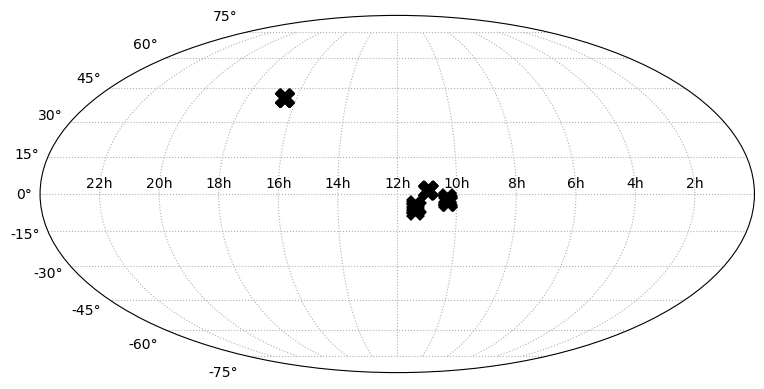

In [42]:
nest_ids = grp_ids 
idx = np.in1d(VI_tab['GroupID'], nest_ids) 
grp_lon = VI_tab['RA_LEDA'][idx]
grp_lat = VI_tab['DEC_LEDA'][idx]

group_coords = SkyCoord(grp_lon, grp_lat, unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in group_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

In [43]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def group_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a group.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the group's coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [44]:
def plot_group_members(groups, group_id, sgacat, sga_ids, rejects, rejcat, rej_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """

    if rejects == True: 
        #- Get cluster sky coordinates
        idx = np.in1d(VI_tab['GroupID'], group_id)
        grp_lon = VI_tab['RA_LEDA'][idx]
        grp_lat = VI_tab['DEC_LEDA'][idx]
        
        group_coord = SkyCoord(grp_lon, grp_lat, unit='deg', frame='icrs')
        
        #- Get SGA galaxy coordinates and median of observations
        idx = np.in1d(sgacat['SGA_ID'], sga_ids)
        z_sga = sgacat['Z_DESI'][idx]
        z_sorted = np.sort(z_sga)
        ngal = len(z_sorted)
        z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
        
        sga_coords = SkyCoord(ra=sgacat['RA_LEDA'][idx], dec=sgacat['DEC_LEDA'][idx], unit='deg', frame='icrs')
        sga_coords_median = group_median_coords(sga_coords)
    
        #- Get rejected SGA galaxy coordinates and median of observations
        idx = np.in1d(rejcat['SGA_ID'], rej_ids)
        z_sga_orig = rejcat['Z_DESI'][idx]
        z_sorted_orig = np.sort(z_sga_orig)
        ngal_orig = len(z_sorted_orig)
        z_sga_median_orig = np.mean(z_sorted_orig[ngal_orig//2:ngal_orig//2 + 2]) if (ngal_orig % 2 == 0) else z_sorted_orig[ngal_orig//2]
        
        sga_coords_orig = SkyCoord(ra=rejcat['RA_LEDA'][idx], dec=rejcat['DEC_LEDA'][idx], unit='deg', frame='icrs')
        sga_coords_median_orig = group_median_coords(sga_coords_orig)
    
        #- Plot the angular coordinates and redshifts
        fig = plt.figure(figsize=(12,8), tight_layout=True)
        ax = plt.subplot(231)#, projection='astro degrees zoom')
        ax.grid()
    
        # transform=ax.get_transform('world'),
        ax.plot(sga_coords_orig.ra.deg, sga_coords_orig.dec.deg, 'ko', alpha=0.5, label=f'{group_id}')
        ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', label=f'{group_id}')
        ax.plot(sga_coords_median.ra.deg, sga_coords_median_orig.dec.deg, 'kD', ms=5, mew=5)
        ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
        
        ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    
        #- Plot the declination vs. redshift and velocity limits
        ax = plt.subplot(232)
        ax.plot(z_sga_orig, sga_coords_orig.dec.deg, 'ko', alpha=0.5, label=f'{group_id}')
        ax.plot(z_sga, sga_coords.dec.deg, 'o', label=f'{group_id}')
        ax.plot(z_sga_median_orig, sga_coords_median_orig.dec.deg, 'kD', ms=5, mew=5)
        ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    
        decmin = np.min(sga_coords_orig.dec.deg) - 0.5
        decmax = np.max(sga_coords_orig.dec.deg) + 0.5
    
        ax.set(xlabel='redshift',
               ylabel=r'$\delta$ [deg]',
               ylim=(decmin, decmax))
    
        #- Plot the RA vs redshift and velocity limits
        ax = plt.subplot(233)
        ax.plot(sga_coords_orig.ra.deg, z_sga_orig, 'ko', alpha=0.5, label=f'{group_id}')
        ax.plot(sga_coords.ra.deg, z_sga, 'o', label=f'{group_id}')
        ax.plot(sga_coords_median_orig.ra.deg, z_sga_median_orig, 'kD', ms=5, mew=5)
        ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
        
        ramin = np.min(sga_coords_orig.ra.deg) - 0.5
        ramax = np.max(sga_coords_orig.ra.deg) + 0.5
    
        ax.set(ylabel='redshift',
               xlabel=r'$\alpha$ [deg]',
               xlim=(ramax, ramin))
    
        #- Histograms of RA, Dec, and redshift:
        delta_angle = 0.75
        
        ax = plt.subplot(234)
        ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
        ax.vlines(sga_coords_median_orig.ra.deg, 0, 50, colors='k', linestyles='dotted')
        ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
        # ax.vlines(group_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')  (DOESN'T WORK WITHOUT CENTER COORD)
        ax.set(xlabel=r'$\alpha$ [deg]',
               xlim=(ramax+delta_angle, ramin-delta_angle),
               ylabel='count',
               ylim=(0,10))
    
        ax = plt.subplot(235)
        ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
        ax.vlines(sga_coords_median_orig.dec.deg, 0, 50, colors='k', linestyles='dotted')
        ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
        # ax.vlines(group_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')  (DOESN'T WORK WITHOUT CENTER COORD)
        ax.set(xlabel=r'$\delta$ [deg]',
               xlim=(decmax+delta_angle, decmin-delta_angle),
               ylabel='count',
               ylim=(0,10))
    
        dz = 0.0025
        zmin = np.min(np.round(z_sga_orig, 2)) - 4*dz
        zmax = np.max(np.round(z_sga_orig, 2)) + 4*dz
    
        ax = plt.subplot(236)
        ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
        ax.vlines(z_sga_median_orig, 0, 50, colors='k', linestyles='dotted')
        ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
        ax.set(xlabel='redshift',
               xlim=(zmin, zmax),
               ylabel='count',
               ylim=(0,10))
        fig.suptitle(f'TF Jura Observations of Tempel et al. Group {group_id}')
    
        med_ra_diff = np.abs(sga_coords_median_orig.ra.deg - sga_coords_median.ra.deg)
        med_dec_diff = np.abs(sga_coords_median_orig.dec.deg - sga_coords_median.dec.deg)
        med_z_diff = np.abs(z_sga_median_orig - z_sga_median)
    
        return fig, med_ra_diff, med_dec_diff, med_z_diff, sga_coords_median, sga_coords_median_orig

    else: 
        #- Get cluster sky coordinates
        idx = np.in1d(VI_tab['GroupID'], group_id)
        grp_lon = VI_tab['RA_LEDA'][idx]
        grp_lat = VI_tab['DEC_LEDA'][idx]
        
        group_coord = SkyCoord(grp_lon, grp_lat, unit='deg', frame='icrs')
        
        #- Get SGA galaxy coordinates and median of observations
        idx = np.in1d(sgacat['SGA_ID'], sga_ids)
        z_sga = sgacat['Z_DESI'][idx]
        z_sorted = np.sort(z_sga)
        ngal = len(z_sorted)
        z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
        
        sga_coords = SkyCoord(ra=sgacat['RA_LEDA'][idx], dec=sgacat['DEC_LEDA'][idx], unit='deg', frame='icrs')
        sga_coords_median = group_median_coords(sga_coords)
    
        #- Plot the angular coordinates and redshifts
        fig = plt.figure(figsize=(12,8), tight_layout=True)
        ax = plt.subplot(231)#, projection='astro degrees zoom')
        ax.grid()
    
        # transform=ax.get_transform('world'),
        ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', label=f'{group_id}')
        ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
        
        ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    
        #- Plot the declination vs. redshift and velocity limits
        ax = plt.subplot(232)
        ax.plot(z_sga, sga_coords.dec.deg, 'o', label=f'{group_id}')
        ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    
        decmin = np.min(sga_coords.dec.deg) - 0.5
        decmax = np.max(sga_coords.dec.deg) + 0.5
    
        ax.set(xlabel='redshift',
               ylabel=r'$\delta$ [deg]',
               ylim=(decmin, decmax))
    
        #- Plot the RA vs redshift and velocity limits
        ax = plt.subplot(233)
        ax.plot(sga_coords.ra.deg, z_sga, 'o', label=f'{group_id}')
        ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
        
        ramin = np.min(sga_coords.ra.deg) - 0.5
        ramax = np.max(sga_coords.ra.deg) + 0.5
    
        ax.set(ylabel='redshift',
               xlabel=r'$\alpha$ [deg]',
               xlim=(ramax, ramin))
    
        #- Histograms of RA, Dec, and redshift:
        delta_angle = 0.75
        
        ax = plt.subplot(234)
        ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
        ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
        # ax.vlines(group_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')  (DOESN'T WORK WITHOUT CENTER COORD)
        ax.set(xlabel=r'$\alpha$ [deg]',
               xlim=(ramax+delta_angle, ramin-delta_angle),
               ylabel='count',
               ylim=(0,10))
    
        ax = plt.subplot(235)
        ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
        ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
        # ax.vlines(group_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')  (DOESN'T WORK WITHOUT CENTER COORD)
        ax.set(xlabel=r'$\delta$ [deg]',
               xlim=(decmax+delta_angle, decmin-delta_angle),
               ylabel='count',
               ylim=(0,10))
    
        dz = 0.0025
        zmin = np.min(np.round(z_sga, 2)) - 4*dz
        zmax = np.max(np.round(z_sga, 2)) + 4*dz
    
        ax = plt.subplot(236)
        ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
        ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
        ax.set(xlabel='redshift',
               xlim=(zmin, zmax),
               ylabel='count',
               ylim=(0,10))
        fig.suptitle(f'TF Jura Observations of Tempel Group {group_id}')
    
        return fig 

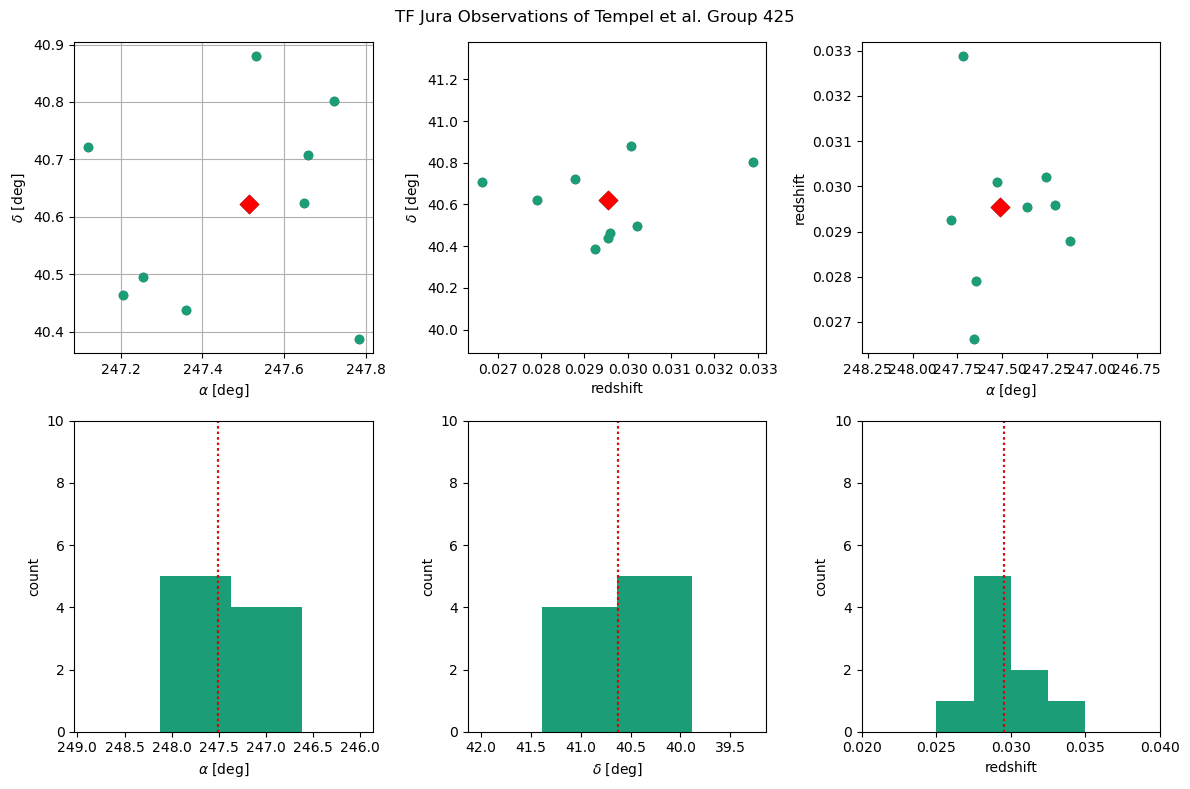

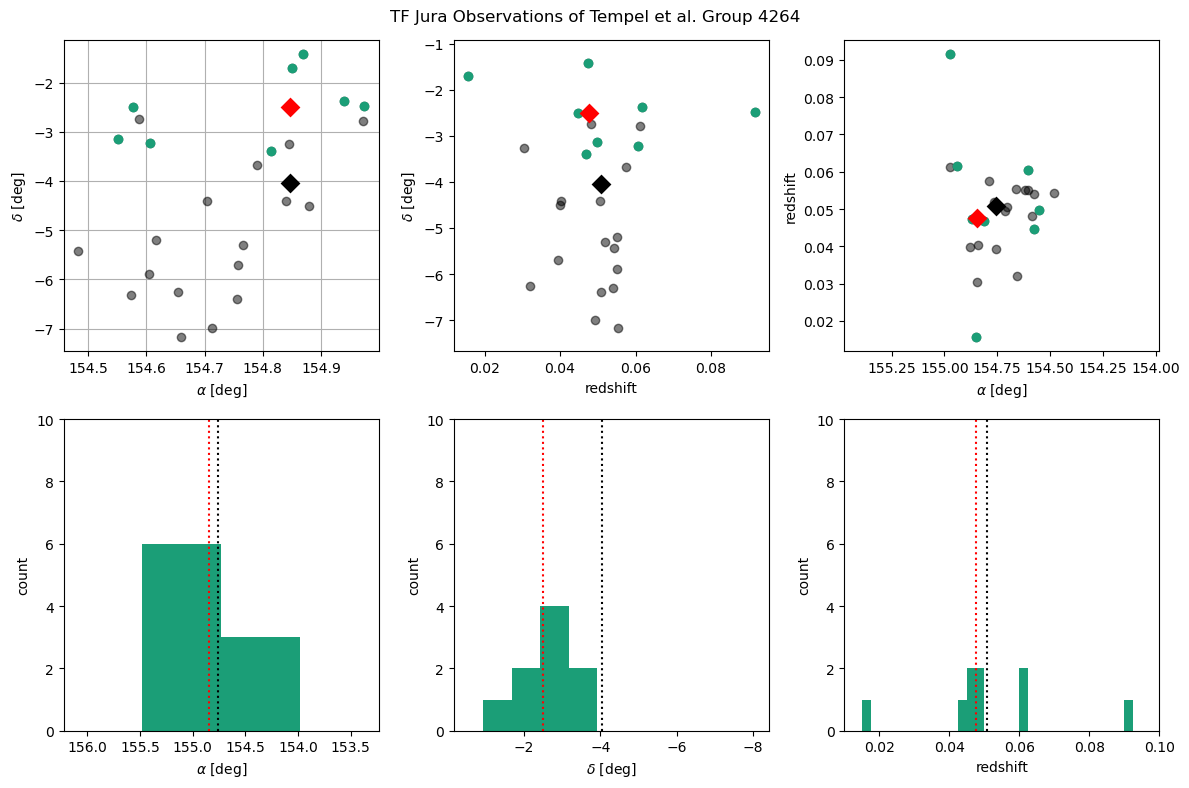

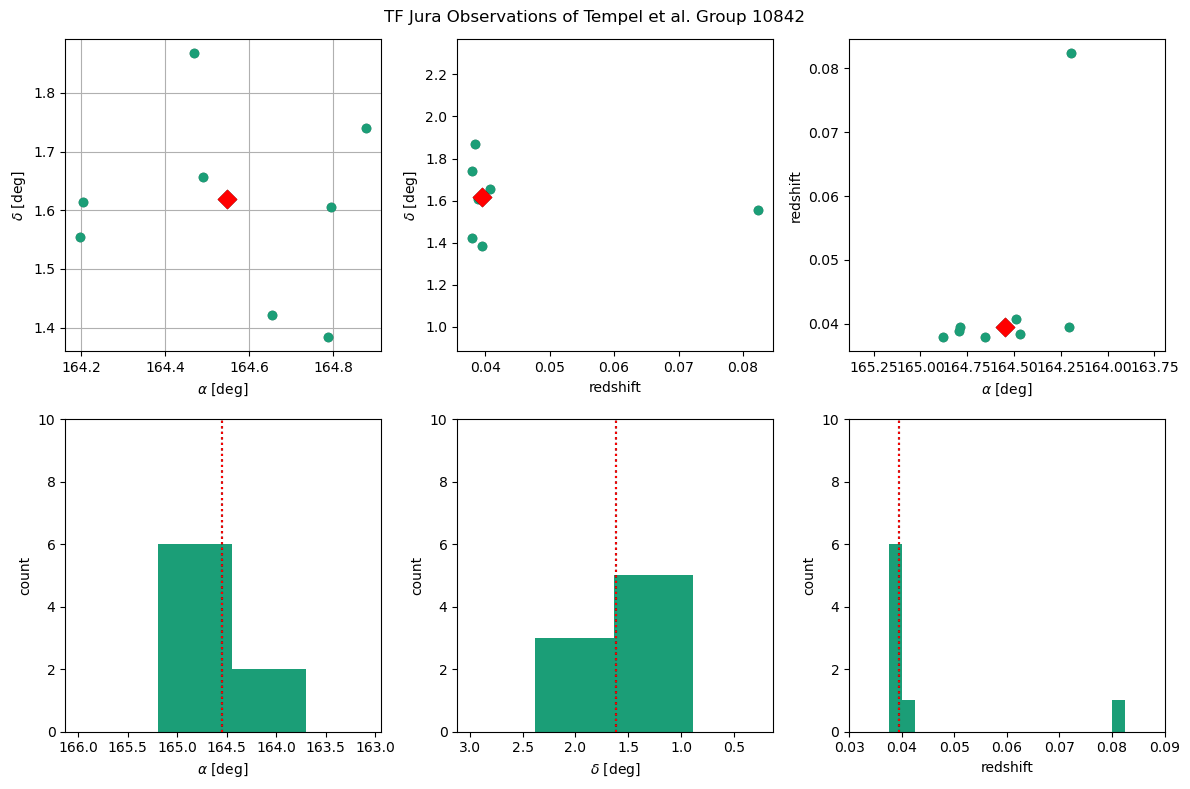

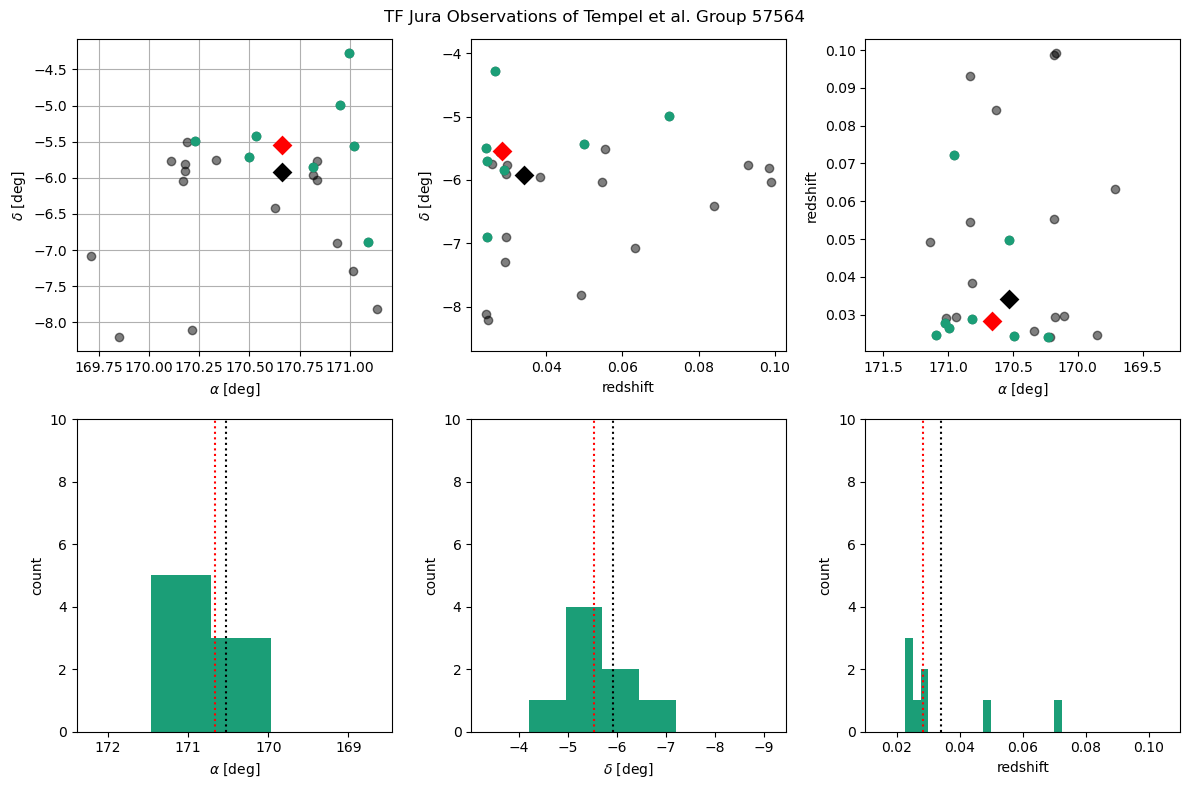

In [45]:
ra_diff = []
dec_diff = []
z_diff = []
median_coords = []
median_coords_orig = []

for group_id in sga_groups.keys():
    fig, med_ra_diff, med_dec_diff, med_z_diff, med_coords, med_coords_orig = plot_group_members(groups, group_id, VI_tab, sga_groups[group_id], True, sgatab_sel, rej_groups[group_id])
    ra_diff.append(med_ra_diff)
    dec_diff.append(med_dec_diff)
    z_diff.append(med_z_diff)
    median_coords.append(med_coords)
    median_coords_orig.append(med_coords_orig)

In [46]:
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

 1     425   9 galaxies
 2    4264   9 galaxies
 3   10842   8 galaxies
 4   57564   8 galaxies


# Apply Cluster Selection

We don't have information like $\angle(R_{2t})$, $v_\text{cluster}$, or $\sigma_P$ for this catalog, so the cluster selection is based off of RA, DEC, and $z$ as plotted above. We calculate the difference between the geometric median cluster center after cuts and the geometric median cluster center before cuts $(RA_\text{med}, DEC_\text{med})$, as well as the difference in median redshifts $z_\text{med}$. 

* $\Delta\theta$: the angular separation between the median position of the selected observations and the total observations.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius. Since this isn't a value in the Tempel catalog, we approximate it using the distance from the median of the total observations to the furthest away point.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, which we don't have and I need to ask Kelly how to approximate, again?

A reasonable selection appears to be
1. $\Delta\theta / \angle(R_{2t}) < 1$
2. $\Delta v/ \sigma_P < 1$ (when I figure out how to get $\sigma_P$)

In [47]:
group_ids = np.asarray(grp_ids)

# print(median_coords)
# print(median_coords_orig)

med_separation = []
max_separation = []
norm_separation = []

for median in range(len(median_coords)): 
    separation = median_coords[median].separation(median_coords_orig[median]).to('rad')
    med_separation.append(separation)

for i in range(len(median_coords_orig)): 
    med = median_coords_orig[i]
    idx = np.in1d(VI_tab['GroupID'], group_ids[i])
    gal = SkyCoord(ra=VI_tab['RA_LEDA'][idx], dec=VI_tab['DEC_LEDA'][idx], unit='deg', frame='icrs')
    max_separation.append(np.max(gal.separation(med).to('rad')))

for n in range(len(med_separation)): 
    norm_separation.append(med_separation[n]/max_separation[n])

print(norm_separation) 
sep_cut_ids = []
sep_cut_ids_rej = []
for i in range(len(norm_separation)): 
    if norm_separation[i] < 2/3: 
        sep_cut_ids.append(group_ids[i])
    else: 
        sep_cut_ids_rej.append(group_ids[i])

keep_group = sep_cut_ids
reject_group = sep_cut_ids_rej
print(keep_group)
print(reject_group)

[<Quantity 0.>, <Quantity 0.5877002>, <Quantity 0.>, <Quantity 0.2367565>]
[425, 4264, 10842, 57564]
[]


In [48]:
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

 1     425   9 galaxies
 2    4264   9 galaxies
 3   10842   8 galaxies
 4   57564   8 galaxies


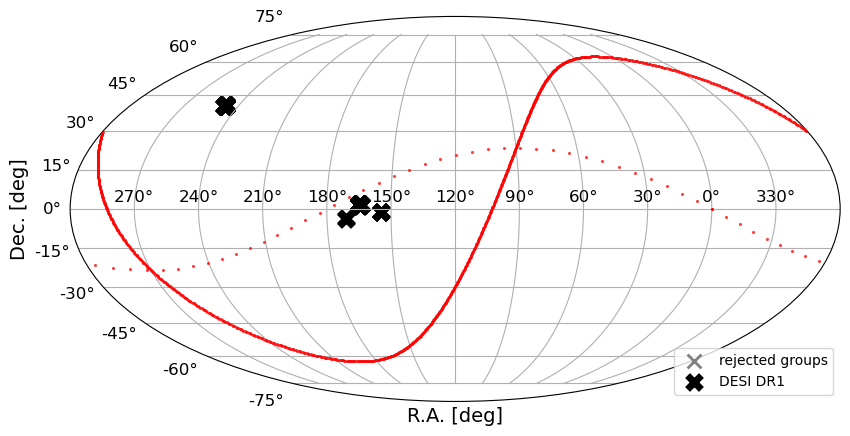

In [49]:
select = grp_ids
grp_ids = np.asarray(list(sga_groups.keys()))
good_idx = np.in1d(groups['GroupID'], keep_group)
bad_idx = np.in1d(groups['GroupID'], reject_group)
good_group_coords = SkyCoord(groups['RAdeg'][good_idx], groups['DEdeg'][good_idx], unit='deg')
bad_group_coords = SkyCoord(groups['RAdeg'][bad_idx], groups['DEdeg'][bad_idx], unit='deg')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_group_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_group_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected groups')

ax.scatter(ax.projection_ra(good_group_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_group_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

## Plot Galaxy Clusters that Failed the Selection

In [50]:
for group_id in sga_groups.keys():
    if group_id in sep_cut_ids_rej:
        fig = plot_group_members(groups, group_id, VI_tab, sga_groups[group_id], False, group_id, group_id)
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

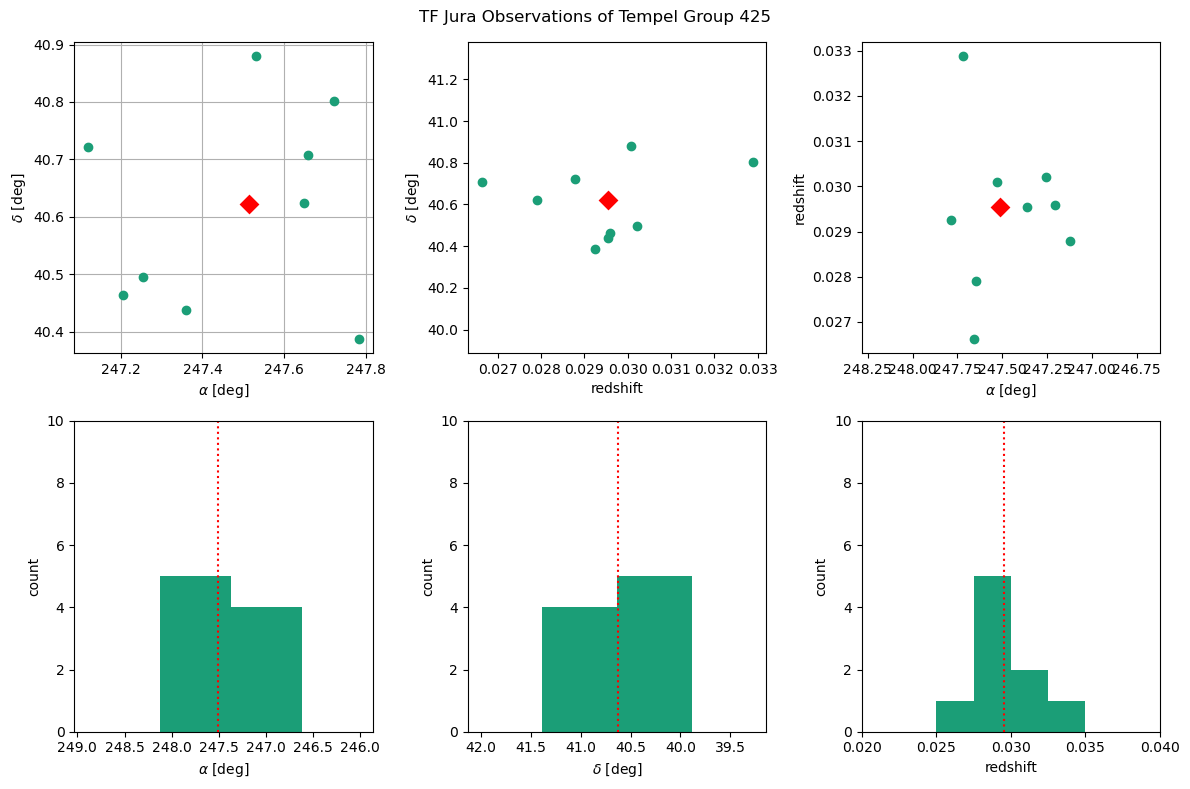

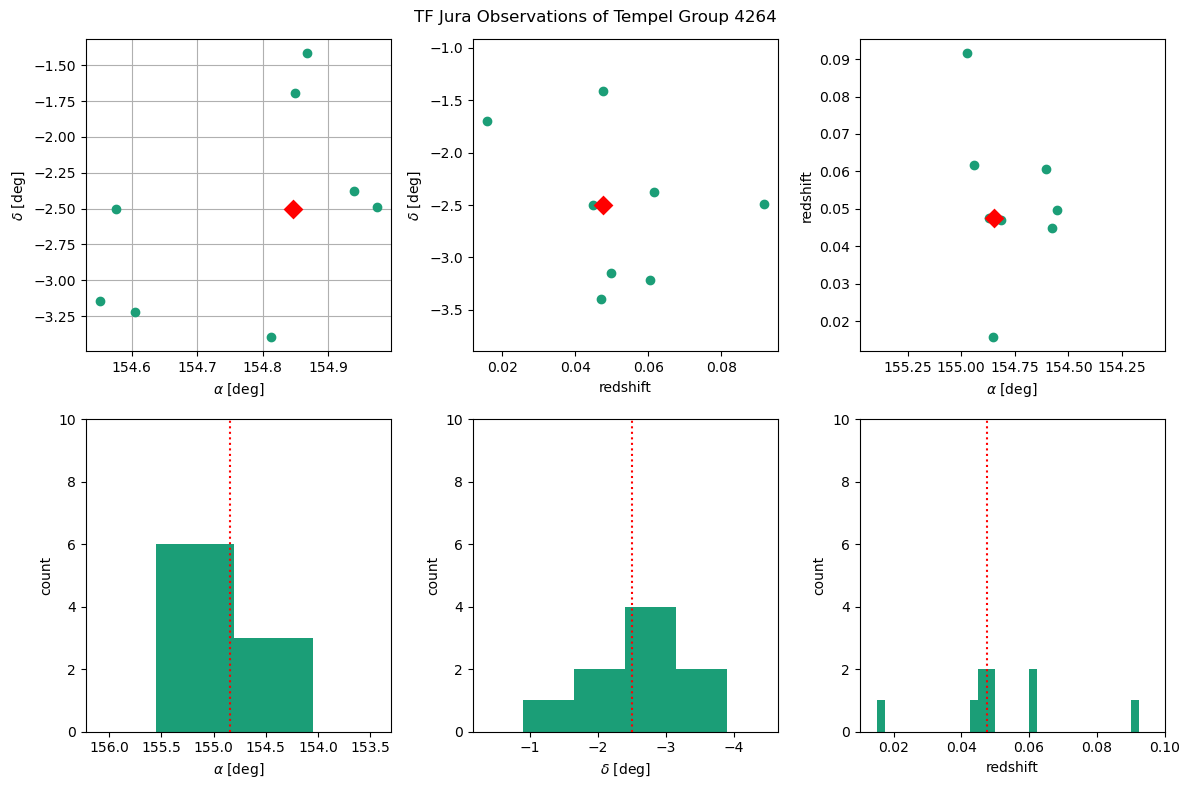

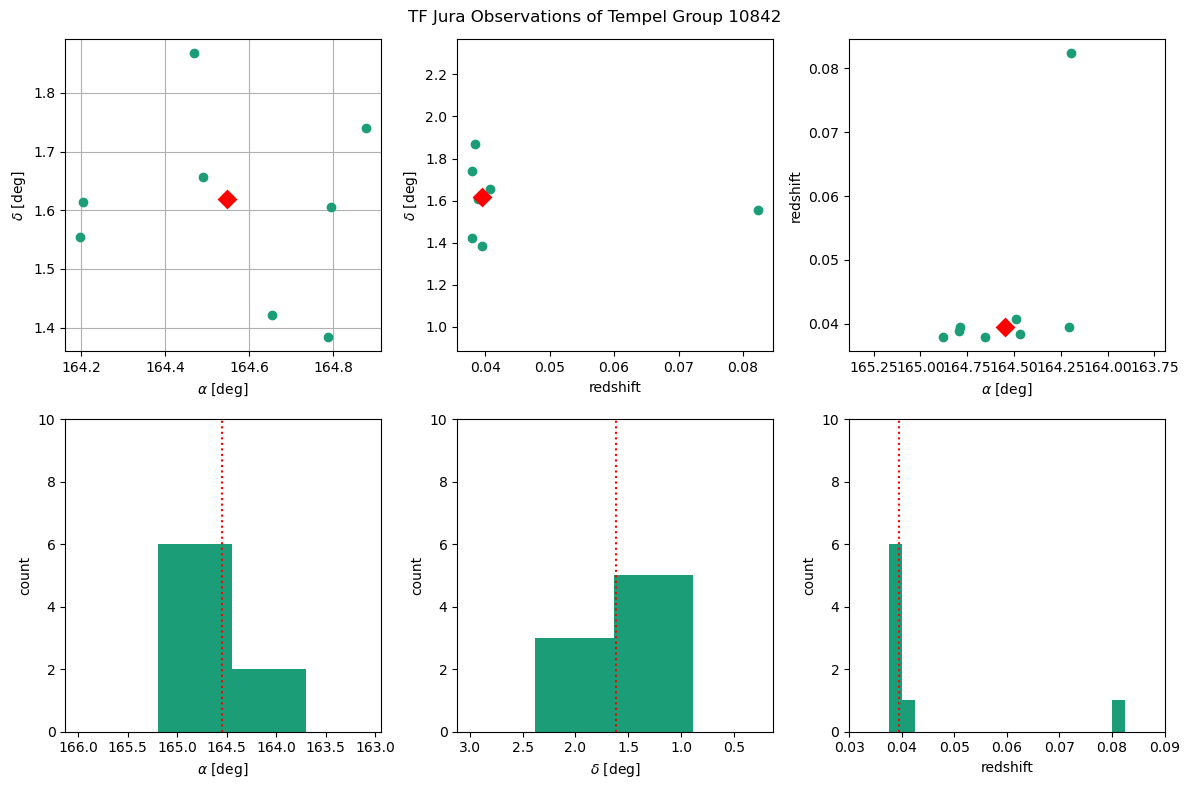

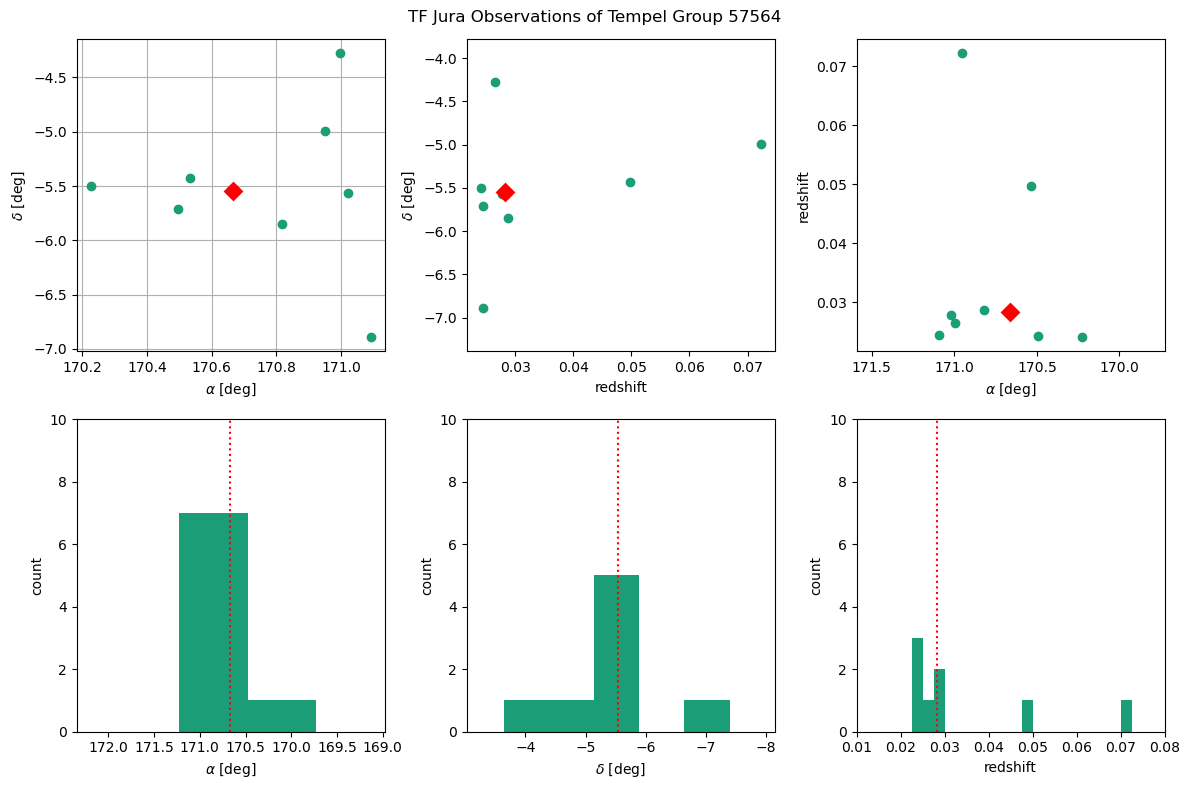

In [51]:
for group_id in sga_groups.keys():
    fig = plot_group_members(groups, group_id, VI_tab, sga_groups[group_id], False, sgatab_sel, rej_groups[group_id])
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [52]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for group_id, sga_ids in sga_groups.items():
    if group_id in keep_group:
        idx = np.in1d(VI_tab['SGA_ID'], sga_ids)
        grouptab = VI_tab[idx]
        grouptab['GROUP_ID'] = group_id
        caltab = grouptab if caltab is None else vstack([caltab, grouptab])
    
    else:
        idx = np.in1d(VI_tab['SGA_ID'], sga_ids)
        grouptab = VI_tab[idx]
        grouptab['GROUP_ID'] = group_id
        
        rejtab = grouptab if rejtab is None else vstack([rejtab, grouptab])
    
# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)

caltab[['GROUP_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']][:5]

GROUP_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_err
int64,float64,float64,float64,float64,float64
425,382620.0,15.058210865130276,0.0733469843337603,101.81516882675562,29.938266100365432
425,633622.0,16.722114506835677,0.09507177243734319,60.77415655536453,1.5279967682916917
425,745318.0,16.124600717745814,0.07778036568741385,33.67485471882046,16.957363925120333
425,821821.0,14.23909275122136,0.11294333659512186,171.7272481110976,1.326040607698855
425,838741.0,14.990295035034977,0.09620487372452509,101.20207560521551,6.682449245430659


In [53]:
# Save SGA IDs for each group that is part of the calibration (for Alex's Bayesian calibration)
for group in np.unique(caltab['GROUP_ID']):
    output_filename = 'output_' + str(group) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['GROUP_ID'] == group].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [54]:
# if any rejected groups, un-comment line to see reject table. 
# rejtab[:5]

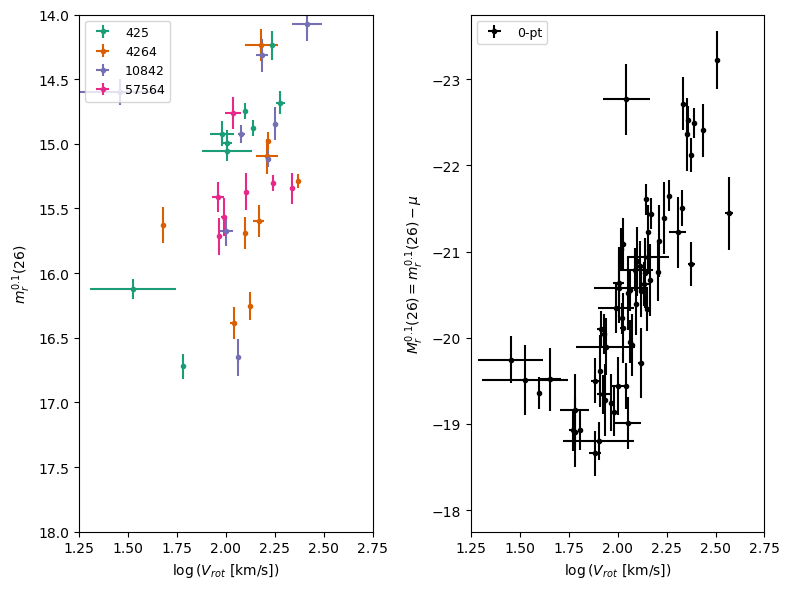

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

# following section commented out because there are no rejected groups—un-comment if there are rejected groups

'''
#- Plot galaxies with failed group selections.
_group_ids = np.unique(rejtab['GROUP_ID'])
markers = 'sDv^<>'
for j, _group_id in enumerate(_group_ids):
    select_group = np.in1d(rejtab['GROUP_ID'], _group_id)

    #- Store independent variable for each group
    logv = np.log10(rejtab['V_0p4R26'][select_group].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_err'][select_group].data / rejtab['V_0p4R26'][select_group].data

    #- Store dependent variable for each group
    mr26 = rejtab['R_MAG_SB26_CORR'][select_group].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_group].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_group_id} (rej.)')
'''

#- Plot galaxies and groups passing all selections.
_group_ids = np.unique(caltab['GROUP_ID'])

for _group_id in _group_ids:
    select_group = np.in1d(caltab['GROUP_ID'], _group_id)

    #- Store independent variable for each group
    logv = np.log10(caltab['V_0p4R26'][select_group].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_group].data / caltab['V_0p4R26'][select_group].data

    #- Store dependent variable for each group
    mr26 = caltab['R_MAG_SB26_CORR'][select_group].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_group].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_group_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18, 14],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='k.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [56]:
#- Extract successful groups
_group_ids = np.unique(caltab['GROUP_ID'])
m = len(_group_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA groups
for k, _group_id in enumerate(_group_ids):
    select_group = np.in1d(caltab['GROUP_ID'], _group_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_group]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_group] / caltab['V_0p4R26'][select_group])
    mag.append(caltab['R_MAG_SB26_CORR'][select_group])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_group])

logV0 = 2.0796559495896583


## Multiline Fit using HyperFit

In [57]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + groups)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -6805.377879166551
     jac: array([-0.03565219, -0.03010427, -0.01955413, -0.01036824, -0.02346496,
        0.01036824, -0.01500666])
 message: 'Optimization terminated successfully.'
    nfev: 7325
     nit: 68
 success: True
       x: array([ -6.57455915, -20.50977456,  14.93369211,  15.76950902,
        15.53700824,  15.31804305,   0.65230166])
Ndim: 7 5


100%|██████████| 1000/1000 [00:08<00:00, 123.00it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.30952796 43.97407777 46.42216788 38.40879837 45.0515866  43.63398699
 45.52971199] / 2321.108394023097


100%|██████████| 1000/1000 [00:07<00:00, 129.62it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.16732406 48.98675026 71.5697499  48.65402824 47.54266698 54.30267908
 50.67113926] / 3578.4874951871443


100%|██████████| 1000/1000 [00:07<00:00, 138.25it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [65.57894638 48.10955351 63.15292693 58.31212081 54.97830362 57.55926492
 64.53441923] / 3278.9473190641856


100%|██████████| 1000/1000 [00:07<00:00, 131.98it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [62.72417656 64.41398649 71.03502714 63.98842961 66.58124534 65.51220228
 64.7497766 ] / 3551.7513568371896


100%|██████████| 1000/1000 [00:09<00:00, 102.06it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [70.48457799 64.11484554 69.38695681 61.74041802 72.33179728 66.17823856
 69.88911624] / 3616.589864163234


100%|██████████| 1000/1000 [00:07<00:00, 136.10it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.95046036 63.93596375 67.80140612 62.34023626 72.09314512 62.52773258
 70.79358956] / 3604.6572557545637


100%|██████████| 1000/1000 [00:07<00:00, 128.84it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [76.6669332  64.95872933 64.59678091 60.36355832 74.00196869 67.72045744
 78.36997077] / 3918.498538279366


100%|██████████| 1000/1000 [00:08<00:00, 124.74it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [74.89876035 63.35082629 68.70357467 67.77961125 73.34587742 66.3718624
 82.56457178] / 4128.228588825185


100%|██████████| 1000/1000 [00:08<00:00, 123.26it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [77.77529446 64.05179856 69.69678682 69.52426055 71.17681828 70.69883499
 82.70219138] / 4135.109569044681


100%|██████████| 1000/1000 [00:07<00:00, 129.70it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [74.59717358 62.5831116  69.99087364 72.78382648 71.1857279  72.62478526
 79.76429488] / 3988.2147439827995


In [58]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_KAD-20241220.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

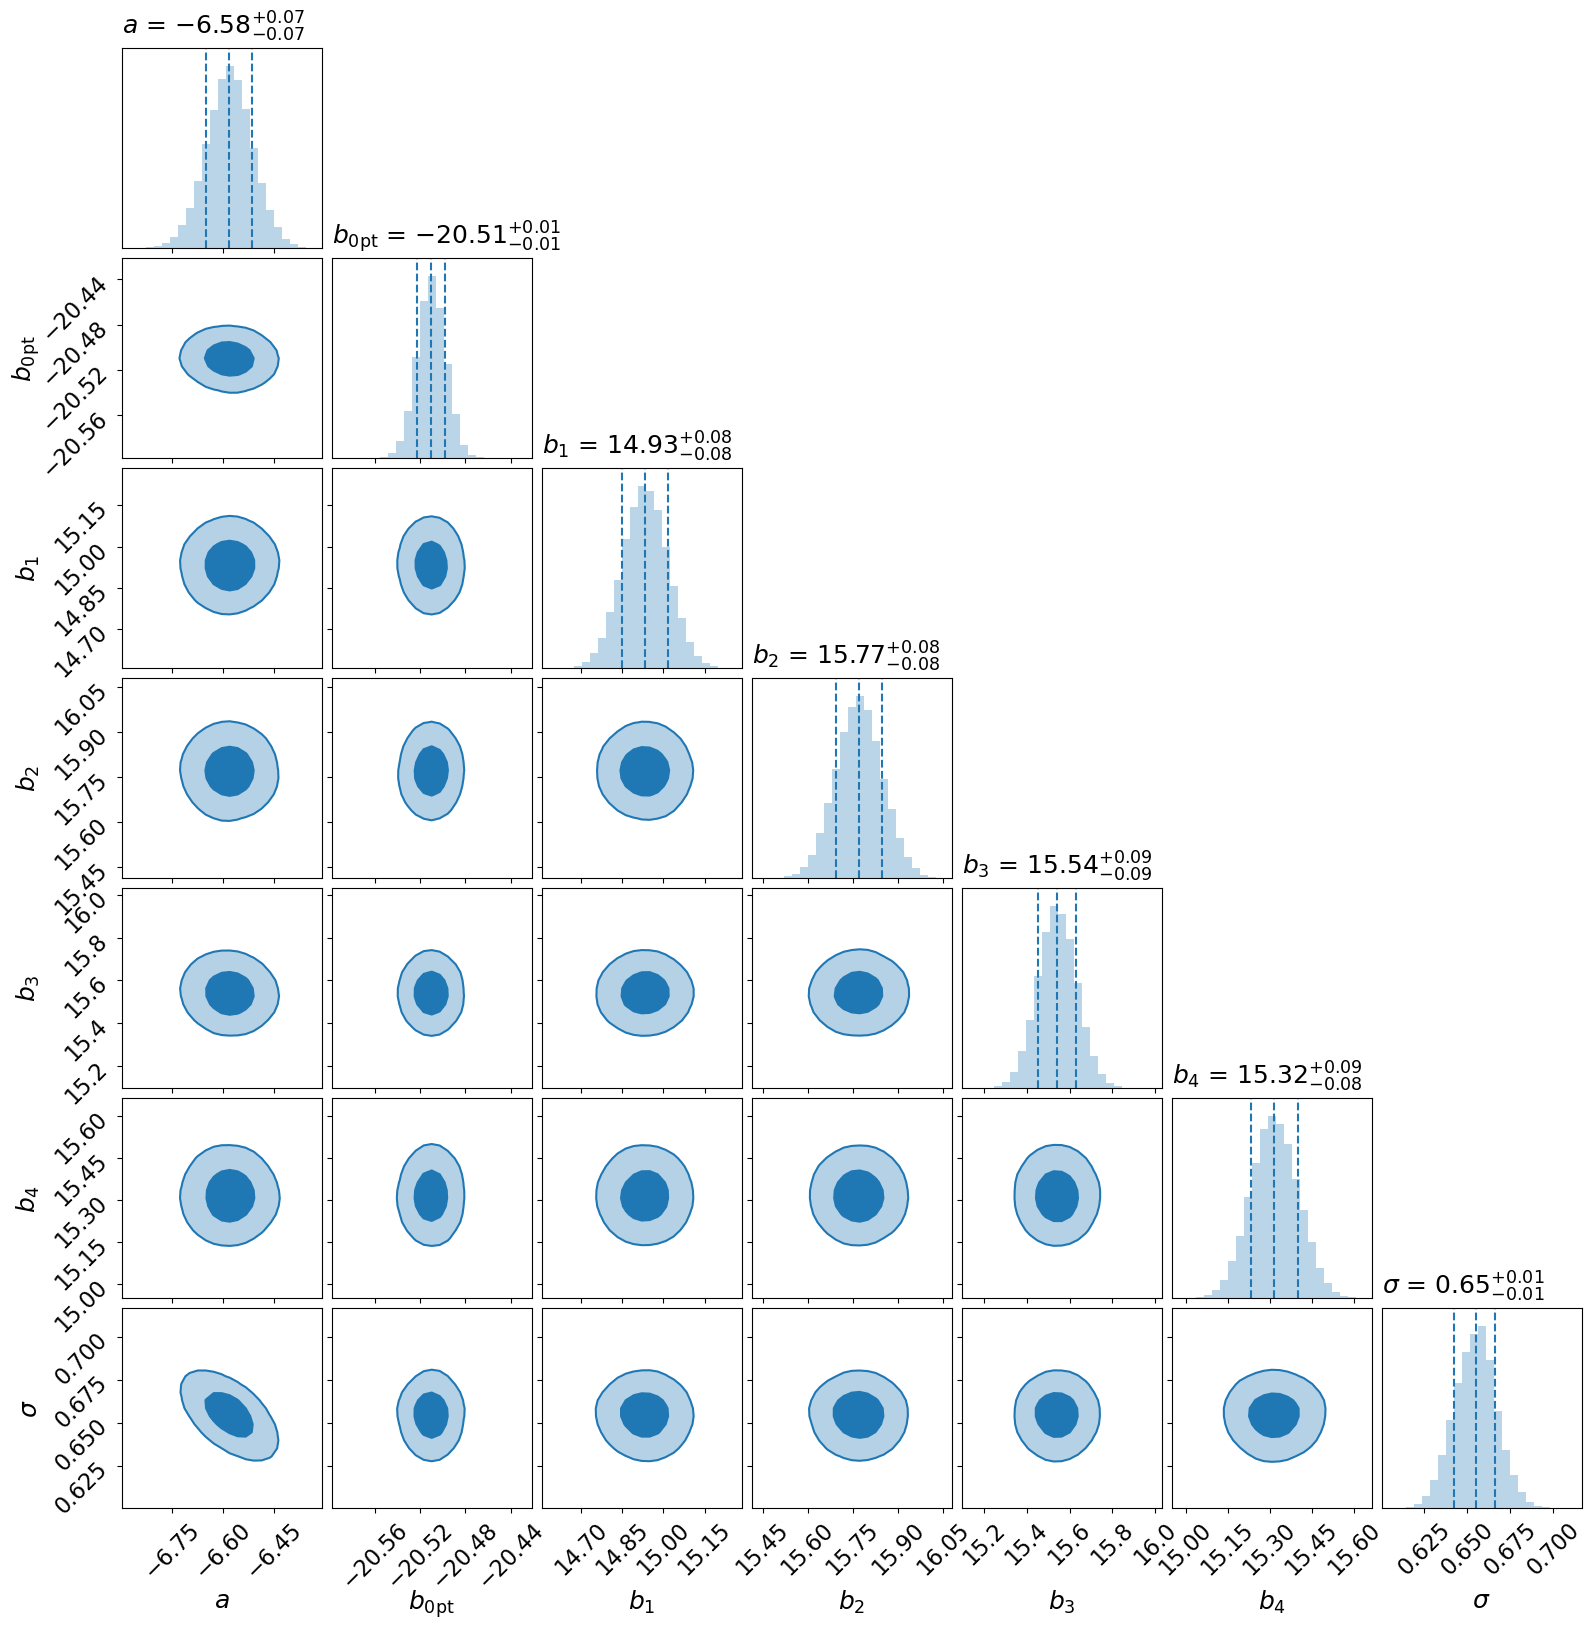

In [59]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_binaryMLupdated_z0p1_corner0_20241220.png', dpi=150, facecolor='none');

### Plot the HyperFit Results

In [60]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

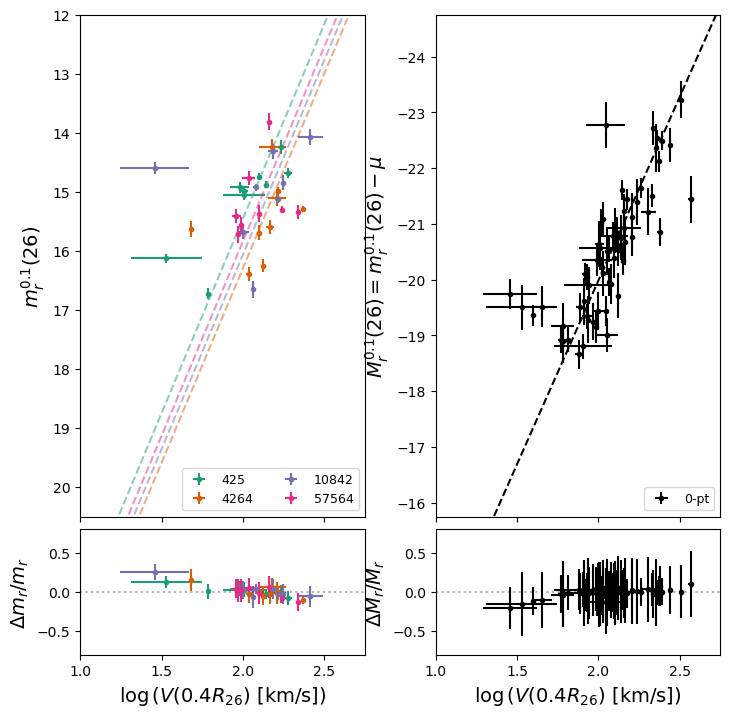

In [61]:
fig, axes = plt.subplots(2,2, figsize=(8, 8), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot groups
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[1, 2.75],
       ylim=[20.5, 12]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1, 2.75],
       ylim=[-15.75, -24.75]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2)

#- Plot residuals: groups
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1, 2.75],
       ylim=[-0.8, 0.8])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='k.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1, 2.75],
       ylim=[-0.8, 0.8])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_0pt_binaryMLupdated_z0p1_fit0_20241220.png', dpi=150, facecolor='none')

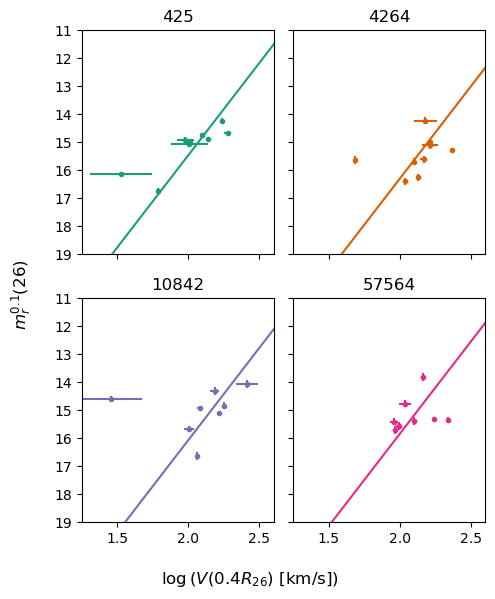

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(5,6), tight_layout=True)

color = iter(tfcolor)
for i in range(m):
    c = next(color)
    
    row = int(i/2)
    col = i%2
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[19, 11], title=f'{_group_ids[i]}')
    
fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [63]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

35.17786524517072 km/s


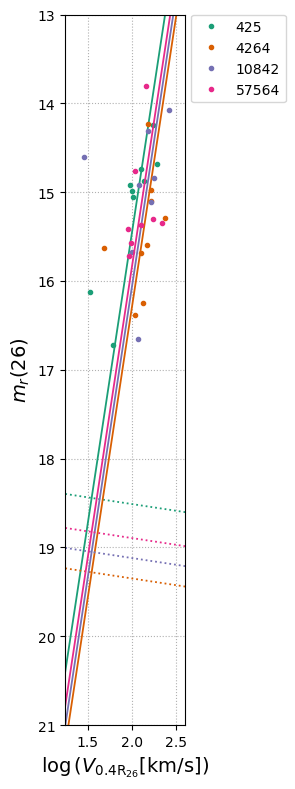

In [64]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_group_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_groups[_group_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 13)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm group \perp}
\end{equation}

In [65]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this group's nest ID
    nestid = _group_ids[i]
    
    # Find all galaxies in this group
    group_gal_idx = caltab['GROUP_ID'] == nestid
    
    # Find which of these group galaxies are dwarfs
    group_dwarfs = (caltab['R_MAG_SB26_CORR'][group_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][group_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][group_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[group_gal_idx] = group_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
